###  Read the Sampled and Cleaned Parquet File from DBFS

In [0]:
taxi_ml_sampled = spark.read.parquet("/dbfs/mnt_1/taxi_ml_sampled")

### Drop Null values

In [0]:
taxi_ml_sampled = taxi_ml_sampled.dropna()

In [0]:
taxi_ml_sampled.count()

99001

### Train Test Split

In [0]:
train_data_sampled, test_data_sampled = taxi_ml_sampled.randomSplit([0.7, 0.3], seed=42)

### Correlation Matrix

In [0]:
# Create the Vector Assembler on the overall taxi sampled database
from pyspark.ml.feature import VectorAssembler

# Select features - Passenger count dropped, MTA & improvement dropped
features = ['year_month', 'day_of_week', 'hour_of_day', 'pickup_borough','dropoff_borough', 'pickup_zone', 'dropoff_zone',
            'trip_duration_hours', 'trip_distance_km', 'speed_kmph', 'tip_amount', 'extra', 'total_amount']

assembler_matrix = VectorAssembler(inputCols=features, outputCol="features")
corr_matrix = assembler_matrix.transform(taxi_ml_sampled)

In [0]:
from pyspark.ml.stat import Correlation

correlation_matrix = Correlation.corr(corr_matrix, "features").head()[0]

# Convert the correlation matrix to a numpy array
correlation_array = correlation_matrix.toArray()

In [0]:
import pandas as pd

# Convert the numpy array to a pandas DataFrame
correlation_df = pd.DataFrame(correlation_array, index=features, columns=features)

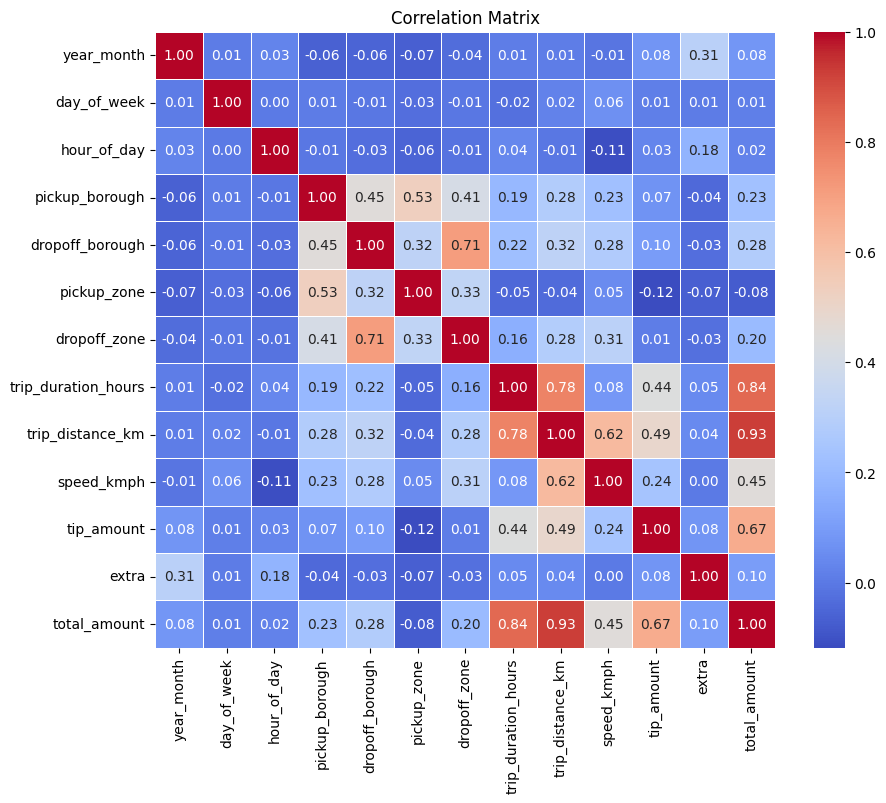

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure size
plt.figure(figsize=(10, 8))

# Create a heatmap for the correlation matrix
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Display the plot
plt.title('Correlation Matrix')
plt.show()


### Vector Assembler

In [0]:
from pyspark.ml.feature import VectorAssembler
selected_features = ['pickup_borough','dropoff_borough', 'trip_duration_hours', 'trip_distance_km', 'speed_kmph', 'tip_amount']

assembler = VectorAssembler(inputCols=selected_features, outputCol="features")

train_data_assembled = assembler.transform(train_data_sampled)
test_data_assembled = assembler.transform(test_data_sampled)

### Scale the Data

In [0]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(train_data_assembled)

train_data_scaled = scaler_model.transform(train_data_assembled)
test_data_scaled = scaler_model.transform(test_data_assembled)

### Linear Regression

In [0]:
# Select the features required for the model
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Create the linear regression model
lr = LinearRegression(featuresCol='scaled_features', labelCol="total_amount", elasticNetParam=0.0, regParam=0.1)

# Train the model
lr_model = lr.fit(train_data_scaled)

# Evaluator
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")

# Evaluate the model on the validation set
test_predictions_lr = lr_model.transform(test_data_scaled)
lr_rmse = evaluator.evaluate(test_predictions_lr)

print(f"Linear Regression RMSE: {lr_rmse}")

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Linear Regression RMSE: 2.9624615658419895


### Random Forest Regressor

In [0]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol='scaled_features', labelCol='total_amount')
rf_model = rf.fit(train_data_scaled)

test_predictions_rf = rf_model.transform(test_data_scaled)
rf_rmse = evaluator.evaluate(test_predictions_rf)

print('Random Forest Regression RMSE: ', rf_rmse)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Random Forest Regression RMSE:  3.3225570778857416


### Comparison

In [0]:
if rf_rmse < lr_rmse:
    best_model = rf_model
    best_model_name = 'Random Forest Regressor'

if lr_rmse < rf_rmse:
    best_model = lr_model
    best_model_name = 'Linear Regression'

print(f'The best Model is: {best_model_name}')

The best Model is: Linear Regression


In [0]:
taxi_ml = spark.read.parquet('/dbfs/mnt_1/taxi_combined.parquet')

### OND prediction

In [0]:
oct_dec_data = taxi_ml.filter((taxi_ml.lpep_pickup_datetime >= '2022-10-01T00:00:00.000') &
                              (taxi_ml.lpep_pickup_datetime <= '2022-12-31T23:59:59.999'))


In [0]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

columns_to_index = {
    "pickup_borough": "pickup_borough_encoded",
    "dropoff_borough": "dropoff_borough_encoded"
}

indexers = [StringIndexer(inputCol=input_col, outputCol=output_col) for input_col, output_col in columns_to_index.items()]

# Create the pipeline with the list of indexers
pipeline = Pipeline(stages=indexers)

# Fit the pipeline and transform the data
oct_dec_data = pipeline.fit(oct_dec_data).transform(oct_dec_data)

# Drop the original columns
oct_dec_data = oct_dec_data.drop(*columns_to_index.keys())

# Rename encoded columns back to original names
for input_col, output_col in columns_to_index.items():
    oct_dec_data = oct_dec_data.withColumnRenamed(output_col, input_col)


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [0]:
oct_dec_data = oct_dec_data.dropna()

In [0]:
selected_features = ['pickup_borough','dropoff_borough', 'trip_duration_hours', 'trip_distance_km', 'speed_kmph', 'tip_amount']

assembler = VectorAssembler(inputCols=selected_features, outputCol="features")

oct_dec_data_assembled = assembler.transform(oct_dec_data)

In [0]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
oct_dec_data_scaled = scaler_model.transform(oct_dec_data_assembled)

In [0]:
lr_model = lr.fit(oct_dec_data_scaled)
oct_dec_predictions = lr_model.transform(oct_dec_data_scaled)
oct_dec_rmse = evaluator.evaluate(oct_dec_predictions)

print(f"Linear Regression RMSE on Oct-Nov-Dec 2022: {oct_dec_rmse}")

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Linear Regression RMSE on Oct-Nov-Dec 2022: 5.8333463149077165
